### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

working_path = "/content/drive/My Drive/Cat_recognition_with_NN/"
!dir "/content/drive/My Drive/Cat_recognition_with_NN/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
App_L_layer_NN_cat_recognition.ipynb  dnn_app_utils_v3.py
datasets			      __pycache__


### Loading data

In [0]:
def load_data():
    train_dataset = h5py.File(working_path + 'datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File(working_path + 'datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [10]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [0]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

### Sigmoid f-ion

In [0]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

### Relu f-ion

In [0]:
def relu(Z):
    
    A = np.maximum(0,Z)
    cache = Z 
    
    return A, cache

### Sigmoid backwards

In [0]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

### Relu backwards

In [0]:
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    return dZ

### Initializing parameters (hyperparameters are given)

In [0]:
 def initialize_parameters(n_x, n_h, n_y):
        
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

### Initializing parameters for L big NN network

In [0]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)           
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/ np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))

    return parameters

In [0]:
def linear_forward(A, W, b):
    
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

In [0]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    
    return A, cache

### Main function for Forward propagation - input X, outputs AL

In [0]:
def L_model_forward(X, parameters):
    
    caches = []
    A = X
    L = len(parameters) // 2  
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation = 'relu')
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], activation = 'sigmoid')
    caches.append(cache)
    
    return AL, caches

### Cost f-ion

In [0]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = (-1/m)*np.sum(np.multiply(Y,np.log(AL))+np.multiply((1-Y),np.log(1-AL)))
    cost = np.squeeze(cost)
    
    return cost

### Two steps of backward propagation
1. Linear backward prop.
2. Linear-Activation backward prop.

In [0]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [0]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

### The whole backward model for accumulating derivatives

In [0]:
def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # Y will has the same shape as AL
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update parameters 

In [0]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
        
    return parameters

### Predict f-ion

In [0]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

### Final model

In [0]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                        
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### Testing an algorithm

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


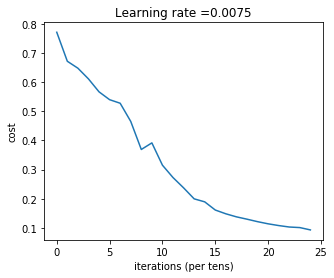

In [28]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [29]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [30]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8
